# 3.0: Figures for pre-study proposal

In [11]:
import os

import cartopy.crs as ccrs
from dotenv import find_dotenv, load_dotenv
import geopandas as gpd
import matplotlib.pyplot as plt

from src.conf.parse_params import config as cfg

load_dotenv(find_dotenv(), override=True)
PROJECT_ROOT = os.environ["PROJECT_ROOT"]

os.chdir(PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the GBIF data clipped to the Sentinel-2 extent.

In [38]:
gbif = gpd.read_parquet(cfg["gbif"]["clipped"])
gbif.head()

,species,geometry
0,Alchemilla monticola,POINT (464536.685 5234518.402)
1,Festuca trachyphylla,POINT (464557.440 5234586.533)
2,Aegopodium podagraria,POINT (449706.899 5234492.183)
3,Erigeron annuus,POINT (449502.208 5234560.493)
4,Medicago sativa,POINT (449609.735 5235128.954)


Load the NaturalEarth high-res world vector file and get the geometry for Germany.

In [59]:
world = gpd.read_file(
    "./data/raw/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
)
# get germany (where featurecla == 'Admin-0 country' and SOVEREIGNT == 'Germany')
germany = world[(world["featurecla"] == "Admin-0 country") & (world["SOVEREIGNT"] == "Germany")]

Reproject the GBIF data to EPSG: 4326 and clip it the extent of Germany's borders.

In [39]:
gbif = gbif.to_crs(world.crs)
# germany = germany.to_crs(gbif.crs)

# Clip gbif to germany boundary
gbif = gpd.clip(gbif, germany)

Plot a density map of GBIF observations across Germany at 1km resolution

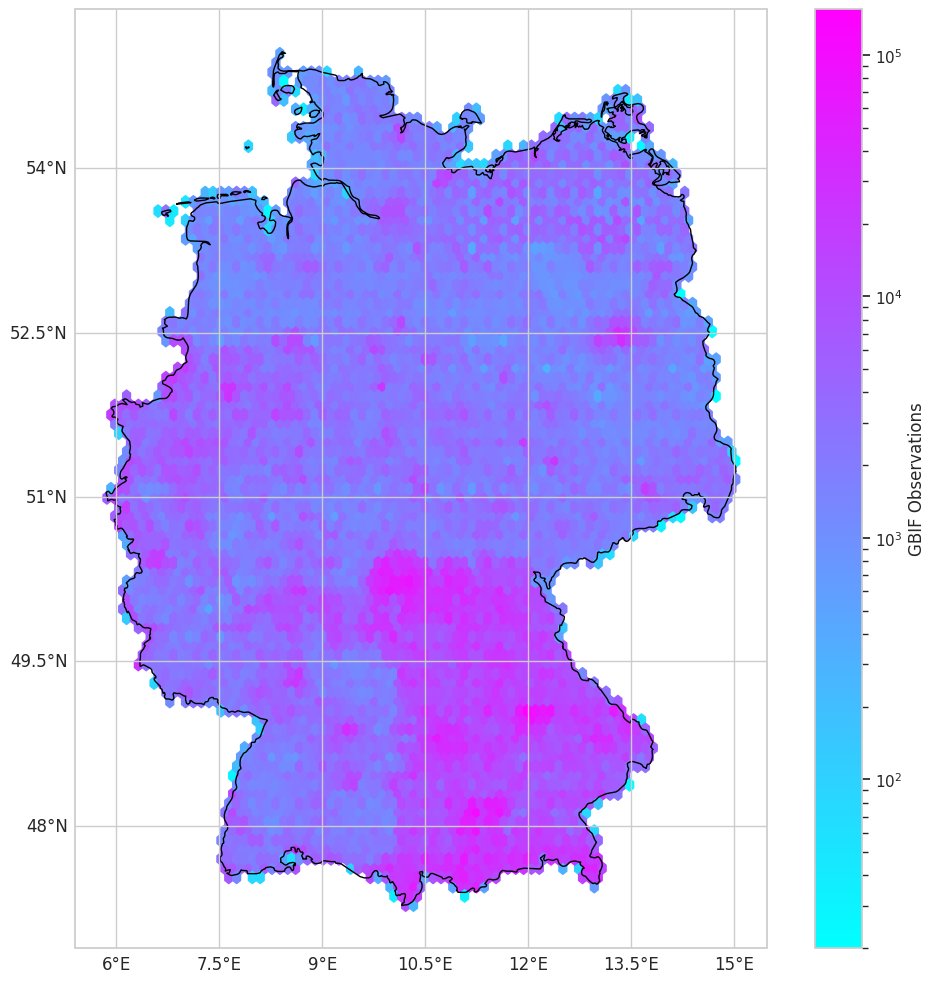

In [58]:
import cartopy.crs as ccrs

# Create a Cartopy GeoAxes with the PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Create the hexbin plot
hb = ax.hexbin(
    gbif.geometry.x,
    gbif.geometry.y,
    gridsize=80,
    cmap="cool",
    bins="log",
    mincnt=20,
    transform=ccrs.PlateCarree(),  # Add this line
)
cb = fig.colorbar(hb, ax=ax)
cb.set_label("GBIF Observations")

# Overlay the map of Germany
germany.boundary.plot(ax=ax, color="black", linewidth=1)

# Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False  # Hide the top labels
gl.right_labels = False  # Hide the right labels

# add some padding between the plot and the colorbar
plt.tight_layout()

# Save the plot
plt.savefig("reports/figures/gbif_observations_germany.png", dpi=300)

plt.show()

Group the GBIF data by species and plot the 10 most abundant species as a histogram.

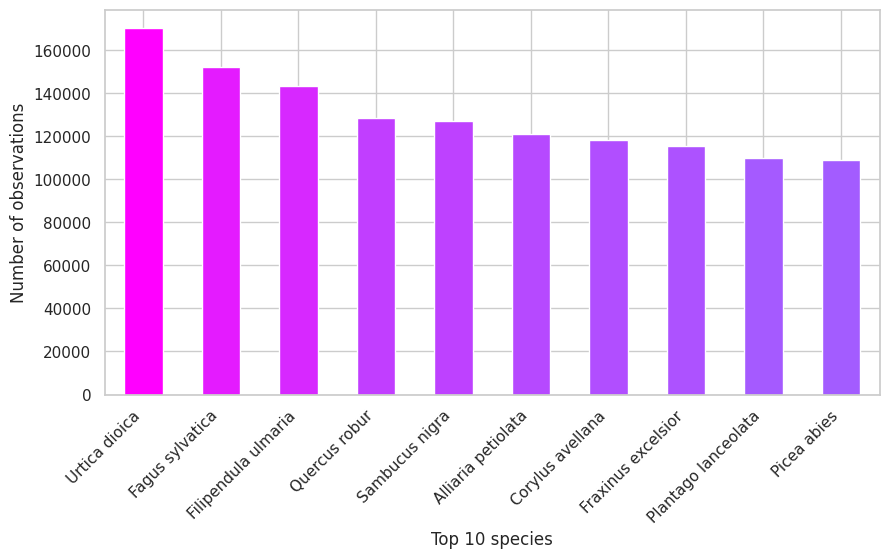

In [56]:
import seaborn as sns

sns.set_theme(style="whitegrid")

species_counts = gbif["species"].value_counts()
top_10_species = species_counts.head(10)

fig, ax = plt.subplots(figsize=(10, 5))

top_10_species.plot(
    kind="bar", ax=ax, color=plt.cm.cool(top_10_species / top_10_species.max())
)

ax.set_xlabel("Top 10 species")
ax.set_ylabel("Number of observations")

plt.xticks(rotation=45, ha="right")

plt.savefig("reports/figures/top_10_species.png", bbox_inches="tight", dpi=300)